In [1]:
from __future__ import division, print_function
import nltk
from nltk import word_tokenize
import pandas as pd
from nltk.corpus import stopwords
import string
import sklearn
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
import gensim 
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize 
import numpy as np
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, Conv2D, GlobalMaxPooling2D
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import os
import collections
import re

Using TensorFlow backend.


In [2]:
df = pd.read_csv('train.csv', 
                   header = None, 
                   delimiter=',')
df.columns = ['Text', 'Label']
df.head()

,Text,Label
0,Well said sonu..you have courage to stand agai...,OAG
1,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG
2,"Now question is, Pakistan will adhere to this?",OAG
3,Pakistan is comprised of fake muslims who does...,OAG
4,"??we r against cow slaughter,so of course it w...",NAG


### Class imbalance problem

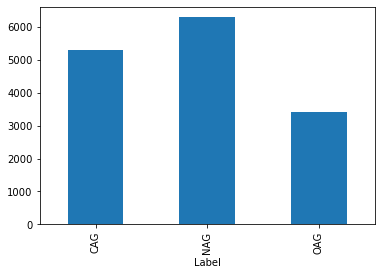

In [115]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [5]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

NAG    6284
CAG    5297
OAG    3419
Name: Label, dtype: int64

### Solving imbalance issue

In [88]:
from collections import Counter
def balanceClasses(xs, ys):
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)

    # the least common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[-1][1])

    num_added = {clss: 0 for clss in freqs.keys()}
    new_ys = []
    new_xs = []
    for i, ym in enumerate(ys):
        if num_added[ym] < max_allowable:
            new_ys.append(ym)
            new_xs.append(xs[i])
            num_added[ym] += 1
    return new_xs, new_ys

In [89]:
new_text, new_label = balanceClasses(df['Text'], df['Label'])


In [90]:
data = pd.DataFrame(new_text)  
data.columns = ['Text']
data['Label'] = new_label

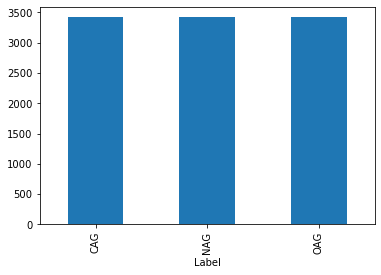

In [91]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [92]:
data.Label.value_counts()

CAG    3419
NAG    3419
OAG    3419
Name: Label, dtype: int64

### Data Preprocessing

In [93]:
# People usually join sentences using more than one colon 
def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceFourColon(x))

In [11]:
#Removing punctuations
data['Text'] = data['Text'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

In [12]:
#Remove Emoji
def RemoveEmoji(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

data['Text'] = data['Text'].apply(lambda x: RemoveEmoji(x))

In [13]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Text'] = data['Text'].apply(lambda x: textPattern(x))

In [14]:
data.head(5)

,Text,Label
0,Well said sonu you have courage to stand again...,OAG
1,Most of Private Banks ATMs Like HDFC ICICI etc...,NAG
2,Now question is Pakistan will adhere to this,OAG
3,Pakistan is comprised of fake muslims who does...,OAG
4,we r against cow slaughterso of course it will...,NAG


In [15]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.Text]

In [94]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [95]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [96]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [97]:
# Removing Stopwords
stoplist = stopwords.words('english')

In [98]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [99]:
OAG  = []
CAG = []
NAG = []
for l in data.Label:
    
    if l == 'OAG':
        OAG.append(1)
        CAG.append(0)
        NAG.append(0)
    elif l == 'CAG':
        OAG.append(0)
        CAG.append(1)
        NAG.append(0)
    elif l == 'NAG':
        OAG.append(0)
        CAG.append(0)
        NAG.append(1)
        
data['OAG']= OAG
data['CAG']= CAG
data['NAG']= NAG

data = data[['Text_Final', 'tokens', 'Label', 'OAG', 'CAG', 'NAG']]

In [100]:
category_id = []
for l in data.Label:
    
    if l == 'OAG':
        category_id.append('0')
    elif l == 'CAG':
        category_id.append('1')
    elif l == 'NAG':
           category_id.append('2')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'Label', 'OAG', 'CAG', 'NAG', 'Category_id' ]]
data.head()

,Text_Final,tokens,Label,OAG,CAG,NAG,Category_id
0,well said sonu courage stand dadagiri muslim,"[well, said, sonu, courage, stand, dadagiri, m...",OAG,1,0,0,0
1,private bank atm like hdfc icici etc cash publ...,"[private, bank, atm, like, hdfc, icici, etc, c...",NAG,0,0,1,2
2,question pakistan adhere,"[question, pakistan, adhere]",OAG,1,0,0,0
3,pakistan comprised fake muslim doe know meanin...,"[pakistan, comprised, fake, muslim, doe, know,...",OAG,1,0,0,0
4,r cow slaughterso course stop leather manufact...,"[r, cow, slaughterso, course, stop, leather, m...",NAG,0,0,1,2


In [101]:
from io import StringIO
category_id_df = data[['Label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'Label']].values)

#### Split Data into test and train
We will use 90 % data for training and 20 % for testing. We use random state so every time we get the same training and testing data.

In [103]:
data_train, data_test = train_test_split(data, test_size=0.20, random_state=42)

In [143]:
# # total training words
totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

# # Storing Length of the training sentence
lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

# # training Vocabulary size
trainingVocabSize = sorted(list(set(totalTrainingWords)))

## Total number of lines
linesCount = len(data_train["tokens"])

### Load Google News Word2Vec model

In [156]:
word2vec_path = 'GoogleNews-vectors-negative300.bin'
#word2vec_path = 'glove.6B.50d.word2vec'

In [157]:
from gensim import models
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)


In [158]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged


In [159]:
def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

### Get Embeddings

In [160]:
trainingEmbeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [164]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

### Tokenize and Pad sequences

In [165]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [166]:
tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 17207 unique tokens.


In [167]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [168]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(17208, 300)


In [169]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)

### Define CNN

In [170]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6,7,8]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=512, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
        
    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model

In [171]:
label_names = ['OAG', 'CAG', 'NAG']

In [172]:
y_train = data_train[label_names].values

In [173]:
x_train = train_cnn_data
y_tr = y_train

In [174]:
y_test = data_test[label_names].values

In [175]:
x_test = test_cnn_data
y_tst = y_test

In [176]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 300)      5162400     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 49, 512)      307712      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 48, 512)      461312      embedding_4[0][0]                
____________________________________________________________________________________________

### Train CNN

In [177]:
num_epochs = 10
batch_size = 512

In [178]:
history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Train on 7384 samples, validate on 821 samples
Epoch 1/10
7384/7384 [==============================] - 28s 4ms/step - loss: 0.8969 - accuracy: 0.6099 - val_loss: 0.6330 - val_accuracy: 0.6719
Epoch 2/10
7384/7384 [==============================] - 26s 4ms/step - loss: 0.5955 - accuracy: 0.6905 - val_loss: 0.5862 - val_accuracy: 0.7020
Epoch 3/10
7384/7384 [==============================] - 27s 4ms/step - loss: 0.5472 - accuracy: 0.7227 - val_loss: 0.5642 - val_accuracy: 0.7040
Epoch 4/10
7384/7384 [==============================] - 27s 4ms/step - loss: 0.5003 - accuracy: 0.7516 - val_loss: 0.5582 - val_accuracy: 0.7024
Epoch 5/10
7384/7384 [==============================] - 27s 4ms/step - loss: 0.4402 - accuracy: 0.7971 - val_loss: 0.5621 - val_accuracy: 0.7048
Epoch 6/10
7384/7384 [==============================] - 27s 4ms/step - loss: 0.3695 - accuracy: 0.8480 - val_loss: 0.5796 - val_accuracy: 0.7048
Epoch 7/10
7384/7384 [==============================] - 27s 4ms/step - loss: 0.2930

In [179]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

2052/2052 [==============================] - 3s 1ms/step


In [180]:
labels = ['OAG', 'CAG', 'NAG']

In [181]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [182]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.5433723196881092

In [183]:
data_test.Label.value_counts()

OAG    690
CAG    686
NAG    676
Name: Label, dtype: int64

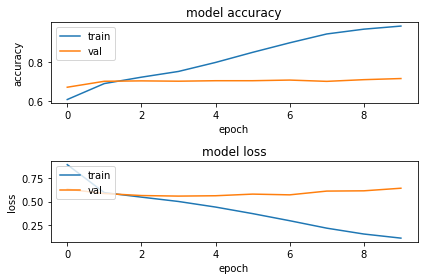

In [194]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [195]:
score = model.evaluate(x_test, y_tst, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2052/2052 [==============================] - 4s 2ms/step
Test loss: 0.6763045288201196
Test accuracy: 0.6132228374481201


In [196]:
results = confusion_matrix(data_test.Label, prediction_labels)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(data_test.Label, prediction_labels))
print ('Report : ')
print (classification_report(data_test.Label, prediction_labels))

Confusion Matrix :
[[323 187 176]
 [177 410  89]
 [211  97 382]]
Accuracy Score : 0.5433723196881092
Report : 
              precision    recall  f1-score   support

         CAG       0.45      0.47      0.46       686
         NAG       0.59      0.61      0.60       676
         OAG       0.59      0.55      0.57       690

    accuracy                           0.54      2052
   macro avg       0.55      0.54      0.54      2052
weighted avg       0.55      0.54      0.54      2052



# Generate SVM Model

In [197]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 4), stop_words='english')
features = vectorizer.fit_transform(data.Text_Final).toarray()
labels = data.Category_id
features.shape

(10257, 6369)

In [198]:
from sklearn.feature_selection import chi2
import numpy as np
N = 4
for Label, Category_id in sorted(category_to_label_dict.items()):
    features_chi2 = chi2(features, labels == Category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    quadgrams = [v for v in feature_names if len(v.split(' ')) == 4]
    
    #print("# '{}':".format(Text_Final))
    #print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    #print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [199]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(data['Text_Final'], data['Label'], random_state = 42)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer() 
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [200]:
print(clf.predict(count_vect.transform(["Modi ho ya Manmohan singh saala yeh log kuch ny karta hai sirf vote ka lia 56 ka seena dikahata hai"])))

['OAG']


In [201]:
print(clf.predict(count_vect.transform(["i am micro investor, need advise on adding stocks on monthly basis !"])))

['NAG']


In [202]:
print(clf.predict(count_vect.transform(["These media fellows have time to dissect one's social media profile,but none of spineless jokers has the guts to question as to why and how a convict like Lalu Yadav is roaming outside and running a Government."])))

['CAG']


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [LinearSVC(), RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features, labels, data.index, test_size=0.20, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# from IPython.display import display
# for predicted in category_id_df.Category_id:
#     for actual in category_id_df.Category_id:
#         if predicted != actual and conf_mat[actual, predicted] >= 10:
#             print("'{}' predicted as '{}' : {} examples.".format(label_to_category_dict[actual], label_to_category_dict[predicted], conf_mat[actual, predicted]))
#         display(data.loc[idx_test[(y_test == actual) & (y_pred == predicted)]][['Label', 'Text_Final']])
#         print('')

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Label'].unique()))

# For Random Forest Method

In [ ]:
model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Label'].unique()))